In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle, utils, tools, plots, lmfit
import warnings
warnings.filterwarnings("ignore")

plt.style.use("style.mplstyle")
path_to_save_plots = "/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Plots/current_correction"
path_to_save_data = "/eos/user/j/jcapotor/RTDdata/corrections"

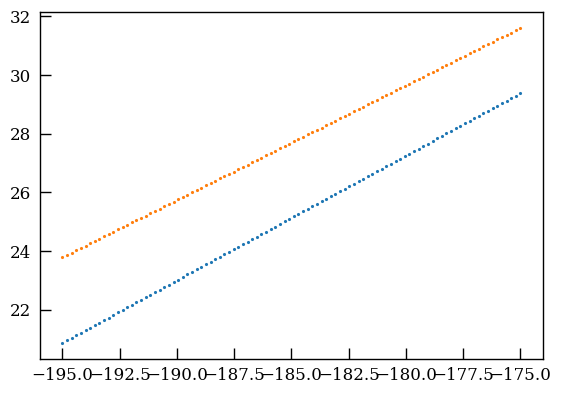

In [2]:
A = 3.90802e-3
B = -5.27742e-7
C= -4.182e-12
R0 = 100

def R(T):
    return R0*(1 + A*T + B*T**2 + C*(T-100)*T**3)

def R_lin(T):
    return R0*(1 + A*T)

temp = np.linspace(-195, -175, 100)
R = R(temp)
R_lin = R_lin(temp)

plt.plot(temp, R, ".")
plt.plot(temp, R_lin, ".")

In [28]:
tini, tend = datetime.datetime(2024, 6, 1, 0, 0, 0), datetime.datetime(2024, 7, 1, 0, 0, 0)
data, data_err = utils.load_data(tini, tend)
poff_data, poff_data_err = utils.load_data(datetime.datetime(2024, 12, 3, 13, 10, 0), datetime.datetime(2024, 12, 3, 14, 25, 0))

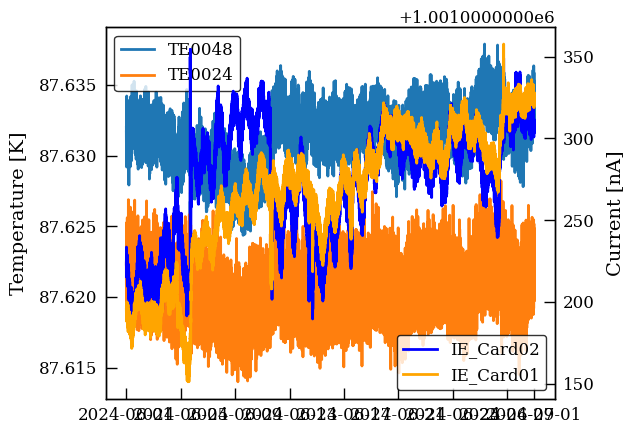

In [35]:
fig, axes = plt.subplots(1, 1)

axes.plot(data.index.to_numpy(), (data["TE0048"]/data["IE_Card02"]).to_numpy(), label="TE0048")
axes.plot(data.index.to_numpy(), (data["TE0020"]/data["IE_Card01"]).to_numpy(), label="TE0024")
#axes.axvline(datetime.datetime(2024, 5, 3, 13, 30, 0), label="Recirculation ON", color="red")
#axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), label="Recirculation ON", color="orange")
axes2 = axes.twinx()
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card02"].to_numpy(), color="blue", label="IE_Card02")
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card01"].to_numpy(), color="orange", label="IE_Card01")
axes.legend()
axes2.legend(loc="lower right")
# axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature [K]")
axes2.set_ylabel("Current [nA]")
# axes.set_title("NP04 Temperature Evolution")
fig.tight_layout()
#fig.savefig(f"{path_to_save_plots}/np04_temp_evolution_TE0048.png", format="png")

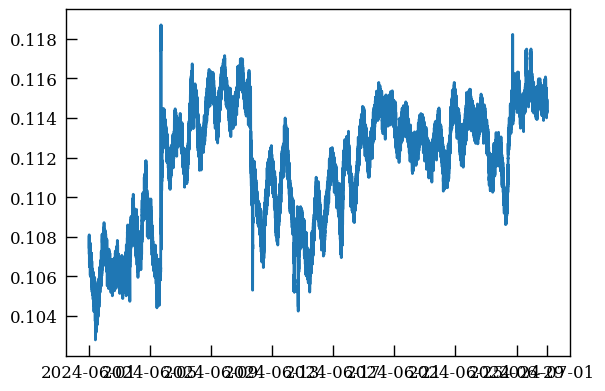

In [36]:
fig, axes = plt.subplots(1, 1)

axes.plot(data.index.to_numpy(),
          (data["TE0048"] - data["TE0048"]/data["IE_Card02"]).to_numpy(),
          label="TE0048")

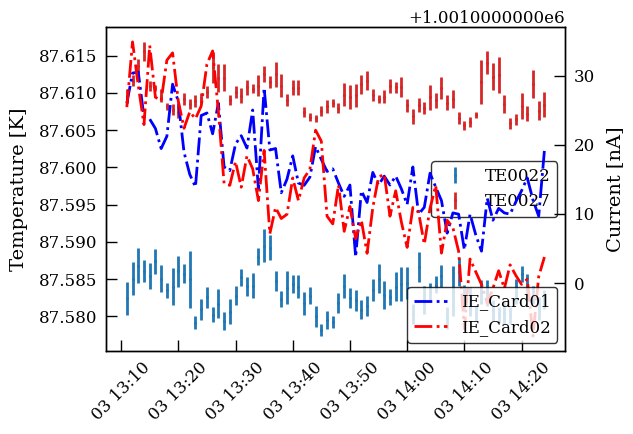

In [26]:
fig, axes = plt.subplots(1, 1)

plots.plot_temp_evolution(
    data=poff_data, data_err=poff_data_err, channel="TE0022",
    tmax=300, tmax_err=1,
    axes=axes
)
plots.plot_temp_evolution(
    data=poff_data, data_err=poff_data_err, channel="TE0027",
    tmax=300, tmax_err=1,
    axes=axes, color="tab:red"
)

axes2 = axes.twinx()
axes2.plot(poff_data.index.to_numpy(), 1e6*poff_data["IE_Card01"].to_numpy(), "-.", color="blue", label="IE_Card01")
axes2.plot(poff_data.index.to_numpy(), 1e6*poff_data["IE_Card02"].to_numpy(), "-.", color="red", label="IE_Card02")
axes.legend()
axes2.legend(loc="lower right")
# axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature [K]")
axes2.set_ylabel("Current [nA]")
# axes.set_title("NP04 Temperature Evolution")
fig.tight_layout()
#fig.savefig(f"{path_to_save_plots}/np04_temp_evolution_TE0048.png", format="png")

Index(['temp', 'DCS-ID', 'SC-ID', 'BOARD', 'SLOT', 'SYSTEM', 'NAME', 'W-CABLE',
       'FLANGE', 'CHAN', 'X', 'Y', 'Z', 'COMMENT', 'COMMENT2', 'temp_err'],
      dtype='object')


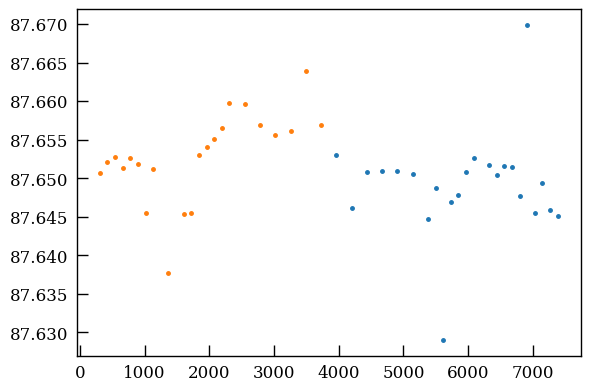

In [27]:
poff_profile = tools.make_tgrad_profile(data=poff_data, data_err=poff_data_err,
                                        path_to_calib="/eos/user/j/jcapotor/RTDdata/calib/TGrad/LAR2023/lar2023_tree_method_avg_path.pkl")
plt.plot(poff_profile["Y"].loc[(poff_profile["BOARD"]==1)].to_numpy(), poff_profile["temp"].loc[(poff_profile["BOARD"]==1)].to_numpy(), "o")
plt.plot(poff_profile["Y"].loc[(poff_profile["BOARD"]==2)].to_numpy(), poff_profile["temp"].loc[(poff_profile["BOARD"]==2)].to_numpy(), "o")
print(poff_profile.columns)

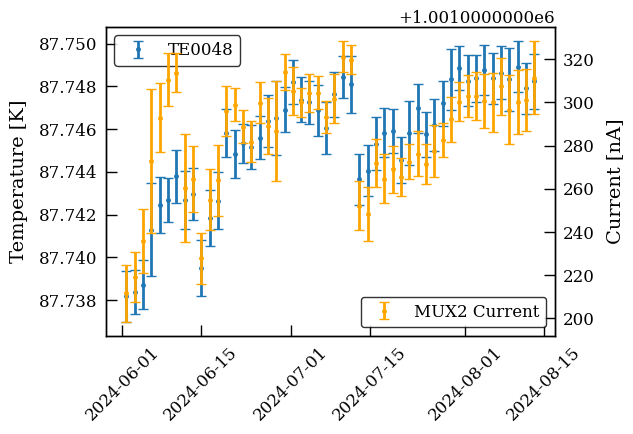

In [ ]:
fig, axes = plt.subplots(1, 1)
a, b, c = tools.tprofile(data, yCol="TE0048", num_bins=50)
axes.errorbar(a.to_numpy(), b, yerr=c, capsize=3.5, fmt="o", label="TE0048")
plt.xticks(rotation=45)
axes2 = axes.twinx()
a, b, c = tools.tprofile(data, yCol="IE_Card02", num_bins=50)
axes2.errorbar(a.to_numpy(), 1e6*b, yerr=1e6*c, fmt="o", capsize=3.5, color="orange", label="MUX2 Current")
axes.legend(loc="upper left")
axes2.legend(loc="lower right")
axes.set_ylabel("Temperature [K]")
# axes.set_xlabel("Datetime")
axes2.set_ylabel("Current [nA]")
fig.tight_layout()
#fig.savefig(f"{path_to_save_plots}/np04_temp_evolution_TE0048_rebin50.png", format="png")

In [15]:
tini1, tend1 = datetime.datetime(2024, 6, 15, 0, 0, 0), datetime.datetime(2024, 7, 13, 0, 0, 0)
data1, data_err1 = utils.load_data(tini1, tend1)
#data1 = data1.loc[(1e6*data1["IE_Card01"]>1.001e6+260)&(1e6*data1["IE_Card01"]<1.001e6+320)&(1e6*data1["IE_Card02"]>1.001e6+260)&(1e6*data1["IE_Card02"]<1.001e6+320)]

tini2, tend2 = datetime.datetime(2024, 7, 15, 0, 0, 0), datetime.datetime(2024, 8, 13, 0, 0, 0)
data2, data_err2 = utils.load_data(tini2, tend2)
#data2 = data1.loc[(1e6*data2["IE_Card01"]>1.001e6+240)&(1e6*data2["IE_Card01"]<1.001e6+320)&(1e6*data2["IE_Card02"]>1.001e6+240)&(1e6*data2["IE_Card02"]<1.001e6+320)]

tini3, tend3 = datetime.datetime(2024, 6, 1, 0, 0, 0), datetime.datetime(2024, 6, 15, 0, 0, 0)
data3, data_err3 = utils.load_data(tini3, tend3)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 46
    # variables        = 2
    chi-square         = 6.05093539
    reduced chi-square = 0.13752126
    Akaike info crit   = -89.3077122
    Bayesian info crit = -85.6504294
    R-squared          = 0.97874140
[[Variables]]
    slope:      94.7932336 +/- 1.80562066 (1.90%) (init = 1)
    intercept: -7.20006275 +/- 1.80793454 (25.11%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -1.0000
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 48
    # variables        = 2
    chi-square         = 8.03316682
    reduced chi-square = 0.17463406
    Akaike info crit   = -81.8058650
    Bayesian info crit = -78.0634630
    R-squared          = 0.96107144
[[Variables]]
    slope:      85.8767450 +/- 2.01149050 (2.34%) (init = 1)
    interce

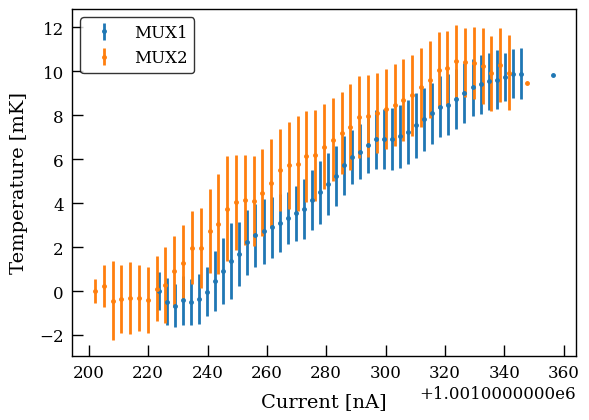

In [3]:
data_rebin1 = data1[["TE0021", "TE0022", "TE0023", "TE0024", "TE0025", "TE0026", "TE0027", "TE0028", "IE_Card01", "IE_Card02"]]
data_rebin1["mean1"] = data_rebin1[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1)
data_rebin1["mean2"] = data_rebin1[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1)
data_MUX1_first = tools.tprofile(data_rebin1, xCol="IE_Card01", yCol="mean1", num_bins=50)
data_MUX2_first = tools.tprofile(data_rebin1, xCol="IE_Card02", yCol="mean2", num_bins=50)

model = lmfit.models.LinearModel()
params = model.make_params(slope=1, intercept=0)
results_MUX1_first = model.fit(data_MUX1_first[1], params, x=data_MUX1_first[0], weights=1/data_MUX1_first[2], nan_policy="omit")
results_MUX2_first = model.fit(data_MUX2_first[1], params, x=data_MUX2_first[0], weights=1/data_MUX2_first[2], nan_policy="omit")

print(results_MUX1_first.fit_report())
print(results_MUX2_first.fit_report())

fig, axes = plt.subplots(1, 1)
axes.errorbar(1e6*data_MUX1_first[0], 1e3*(data_MUX1_first[1] - data_MUX1_first[1][0]), yerr=1e3*data_MUX1_first[2], fmt="o", label="MUX1")
axes.errorbar(1e6*data_MUX2_first[0], 1e3*(data_MUX2_first[1] - data_MUX2_first[1][0]), yerr=1e3*data_MUX2_first[2], fmt="o", label="MUX2")
axes.set_xlabel("Current [nA]")
axes.set_ylabel("Temperature [mK]")
axes.legend()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 50
    # variables        = 2
    chi-square         = 6.12699456
    reduced chi-square = 0.12764572
    Akaike info crit   = -100.965933
    Bayesian info crit = -97.1418870
    R-squared          = 0.95270251
[[Variables]]
    slope:      59.7500162 +/- 1.72687319 (2.89%) (init = 1)
    intercept:  27.8910510 +/- 1.72907247 (6.20%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -1.0000
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 50
    # variables        = 2
    chi-square         = 2.25691468
    reduced chi-square = 0.04701906
    Akaike info crit   = -150.901216
    Bayesian info crit = -147.077170
    R-squared          = 0.97816160
[[Variables]]
    slope:      67.0195682 +/- 1.43772889 (2.15%) (init = 1)
    intercep

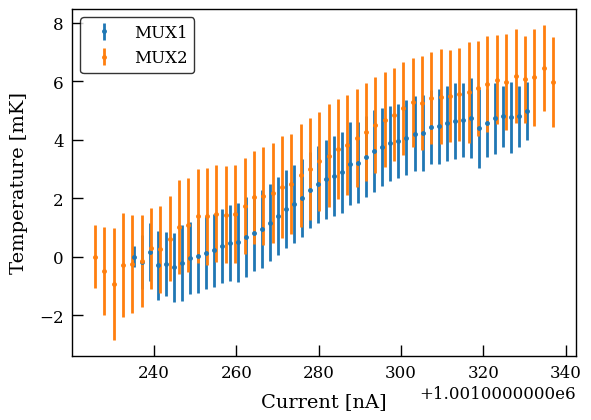

In [4]:
data_rebin2 = data2[["TE0021", "TE0022", "TE0023", "TE0024", "TE0025", "TE0026", "TE0027", "TE0028", "IE_Card01", "IE_Card02"]]
data_rebin2["mean1"] = data_rebin2[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1)
data_rebin2["mean2"] = data_rebin2[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1)
data_MUX1_second = tools.tprofile(data_rebin2, xCol="IE_Card01", yCol="mean1", num_bins=50)
data_MUX2_second = tools.tprofile(data_rebin2, xCol="IE_Card02", yCol="mean2", num_bins=50)

model = lmfit.models.LinearModel()
params = model.make_params(slope=1, intercept=0)
results_MUX1_second = model.fit(data_MUX1_second[1], params, x=data_MUX1_second[0], weights=1/data_MUX1_second[2], nan_policy="omit")
results_MUX2_second = model.fit(data_MUX2_second[1], params, x=data_MUX2_second[0], weights=1/data_MUX2_second[2], nan_policy="omit")

print(results_MUX1_second.fit_report())
print(results_MUX2_second.fit_report())

fig, axes = plt.subplots(1, 1)
axes.errorbar(1e6*data_MUX1_second[0], 1e3*(data_MUX1_second[1] - data_MUX1_second[1][0]), yerr=1e3*data_MUX1_second[2], fmt="o", label="MUX1")
axes.errorbar(1e6*data_MUX2_second[0], 1e3*(data_MUX2_second[1] - data_MUX2_second[1][0]), yerr=1e3*data_MUX2_second[2], fmt="o", label="MUX2")
axes.set_xlabel("Current [nA]")
axes.set_ylabel("Temperature [mK]")
axes.legend()

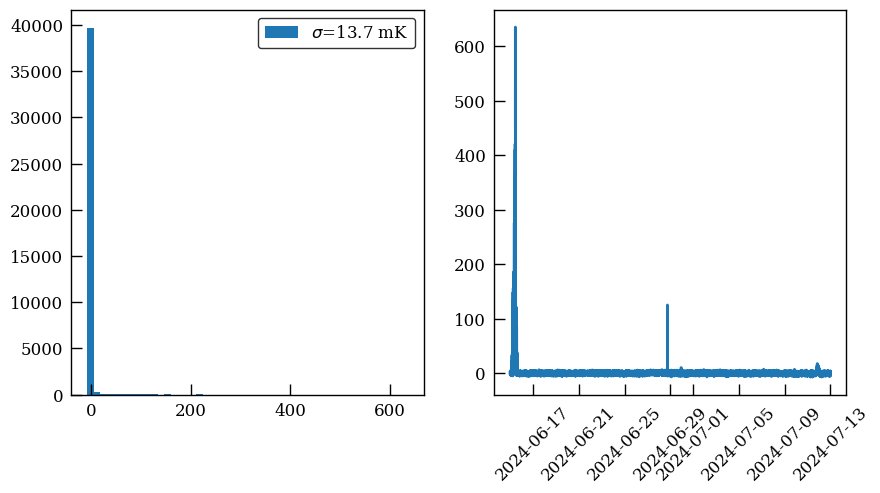

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data_corr = data1.copy()

from scipy.interpolate import interp1d

x_MUX1, y_MUX1, _ = data_MUX1_second
x_MUX2, y_MUX2, _ = data_MUX2_second
interp_func1 = interp1d(x_MUX1, y_MUX1, kind="cubic", fill_value="extrapolate")
interp_func2 = interp1d(x_MUX2, y_MUX2, kind="cubic", fill_value="extrapolate")

data_corr["mean1"] = data_corr[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1) - interp_func1(data_corr["IE_Card01"])
data_corr["mean2"] = data_corr[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1) - interp_func2(data_corr["IE_Card02"])

plt.xticks(rotation=45)
axes[1].plot(data_corr.index.to_numpy(), 1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy())
axes[0].hist(1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy(), bins=50, label=fr'$\sigma$={1e3*(data_corr["mean2"]-data_corr["mean1"]).std():.1f} mK');
axes[0].legend();

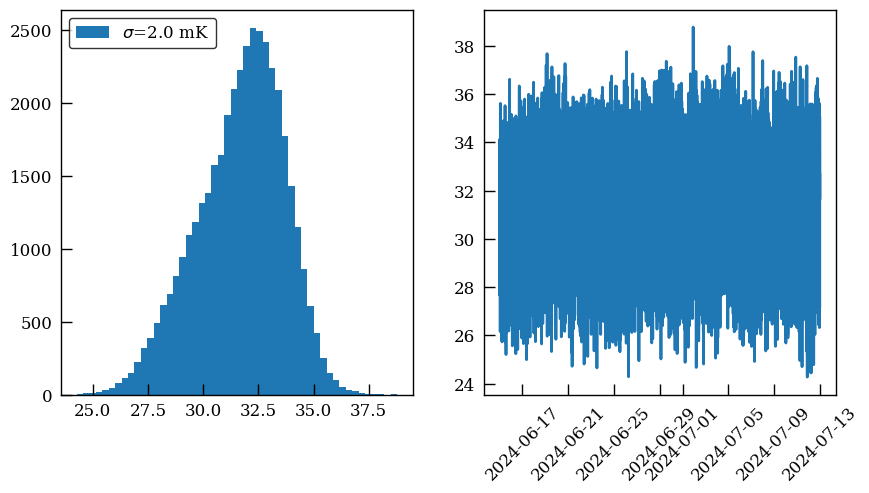

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data_corr = data1.copy()

from scipy.interpolate import interp1d

x_MUX1, y_MUX1, _ = data_MUX1_second
x_MUX2, y_MUX2, _ = data_MUX2_second
interp_func1 = interp1d(x_MUX1, y_MUX1, kind="cubic", fill_value="extrapolate")
interp_func2 = interp1d(x_MUX2, y_MUX2, kind="cubic", fill_value="extrapolate")

data_corr["mean1"] = data_corr[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1)
data_corr["mean2"] = data_corr[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1)

plt.xticks(rotation=45)
axes[1].plot(data_corr.index.to_numpy(), 1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy())
axes[0].hist(1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy(), bins=50, label=fr'$\sigma$={1e3*(data_corr["mean2"]-data_corr["mean1"]).std():.1f} mK');
axes[0].legend();

<ErrorbarContainer object of 3 artists>

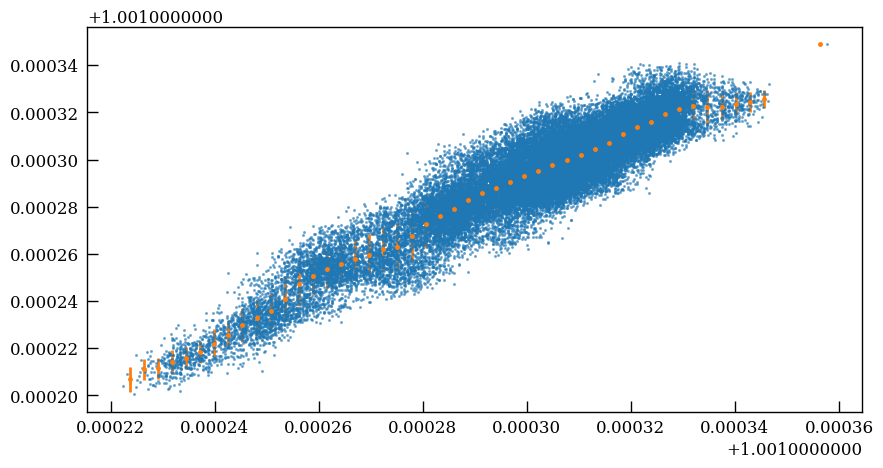

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(data_corr["IE_Card01"].to_numpy(), data_corr["IE_Card02"].to_numpy(), ".", alpha=0.5)
data_rebin = tools.tprofile(data_corr, xCol="IE_Card01", yCol="IE_Card02", num_bins=50)
axes.errorbar(data_rebin[0], data_rebin[1], data_rebin[2], fmt="o")

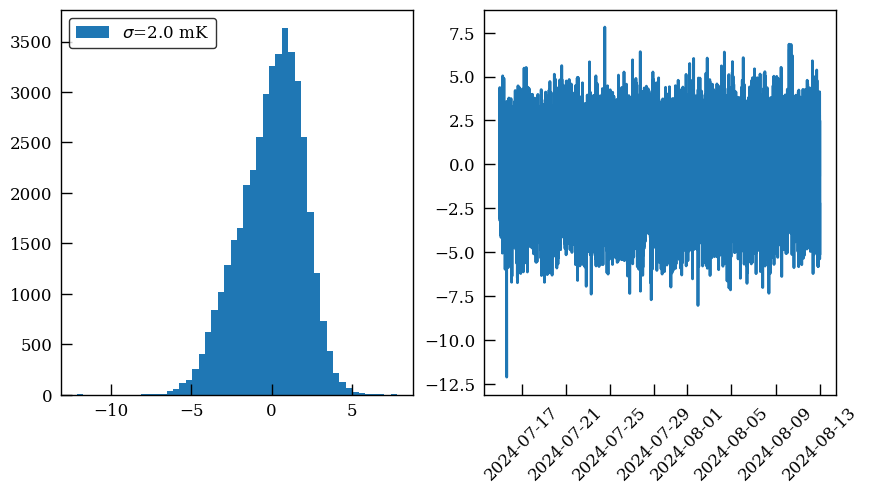

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data_corr = data2.copy()

from scipy.interpolate import interp1d

x_MUX1, y_MUX1, _ = data_MUX1_second
x_MUX2, y_MUX2, _ = data_MUX2_second
interp_func1 = interp1d(x_MUX1, y_MUX1, kind="cubic", fill_value="extrapolate")
interp_func2 = interp1d(x_MUX2, y_MUX2, kind="cubic", fill_value="extrapolate")

data_corr["mean1"] = data_corr[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1) - interp_func1(data_corr["IE_Card01"])
data_corr["mean2"] = data_corr[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1) - interp_func2(data_corr["IE_Card02"])

plt.xticks(rotation=45)
axes[1].plot(data_corr.index.to_numpy(), 1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy())
axes[0].hist(1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy(), bins=50, label=fr'$\sigma$={1e3*(data_corr["mean2"]-data_corr["mean1"]).std():.1f} mK');
axes[0].legend();

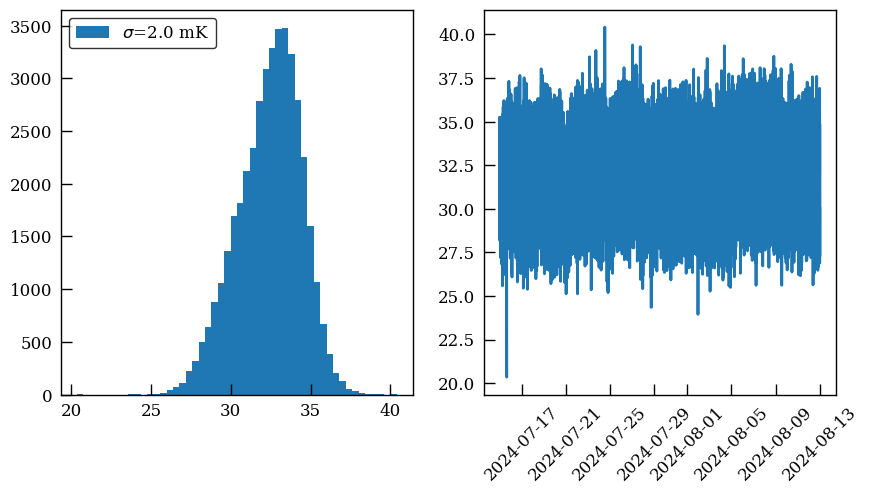

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data_corr = data2.copy()

from scipy.interpolate import interp1d

x_MUX1, y_MUX1, _ = data_MUX1_second
x_MUX2, y_MUX2, _ = data_MUX2_second
interp_func1 = interp1d(x_MUX1, y_MUX1, kind="cubic", fill_value="extrapolate")
interp_func2 = interp1d(x_MUX2, y_MUX2, kind="cubic", fill_value="extrapolate")

data_corr["mean1"] = data_corr[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1)
data_corr["mean2"] = data_corr[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1)

plt.xticks(rotation=45)
axes[1].plot(data_corr.index.to_numpy(), 1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy())
axes[0].hist(1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy(), bins=50, label=fr'$\sigma$={1e3*(data_corr["mean2"]-data_corr["mean1"]).std():.1f} mK');
axes[0].legend();

<ErrorbarContainer object of 3 artists>

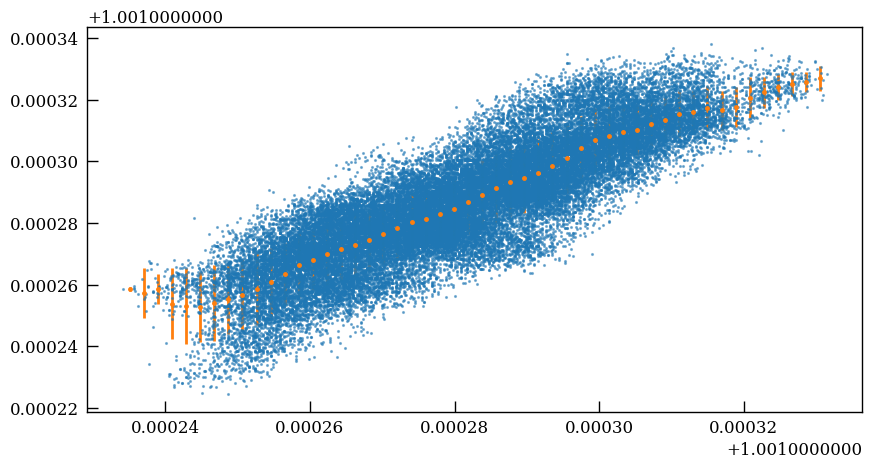

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(data_corr["IE_Card01"].to_numpy(), data_corr["IE_Card02"].to_numpy(), ".", alpha=0.5)
data_rebin = tools.tprofile(data_corr, xCol="IE_Card01", yCol="IE_Card02", num_bins=50)
axes.errorbar(data_rebin[0], data_rebin[1], data_rebin[2], fmt="o")

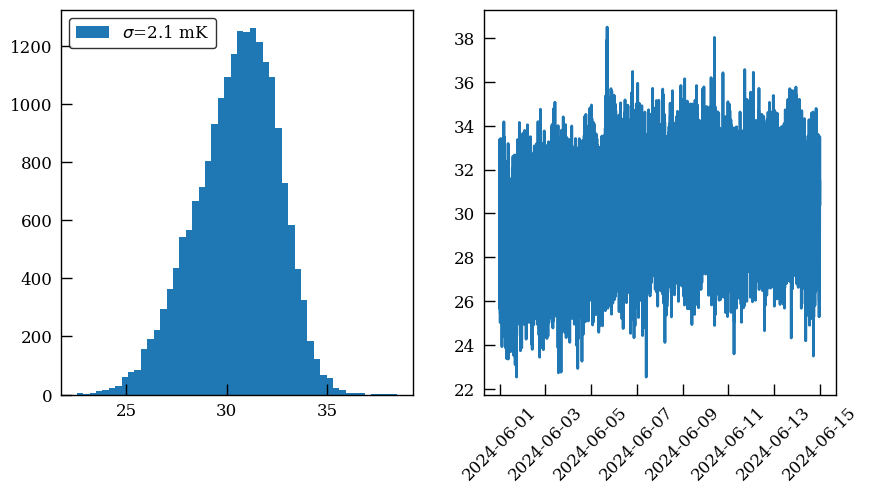

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data_corr = data3.copy()

from scipy.interpolate import interp1d

x_MUX1, y_MUX1, _ = data_MUX1_second
x_MUX2, y_MUX2, _ = data_MUX2_second
interp_func1 = interp1d(x_MUX1, y_MUX1, kind="cubic", fill_value="extrapolate")
interp_func2 = interp1d(x_MUX2, y_MUX2, kind="cubic", fill_value="extrapolate")

data_corr["mean1"] = data_corr[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1)
data_corr["mean2"] = data_corr[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1)

plt.xticks(rotation=45)
axes[1].plot(data_corr.index.to_numpy(), 1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy())
axes[0].hist(1e3*(data_corr["mean2"]-data_corr["mean1"]).to_numpy(), bins=50, label=fr'$\sigma$={1e3*(data_corr["mean2"]-data_corr["mean1"]).std():.1f} mK');
axes[0].legend();

<ErrorbarContainer object of 3 artists>

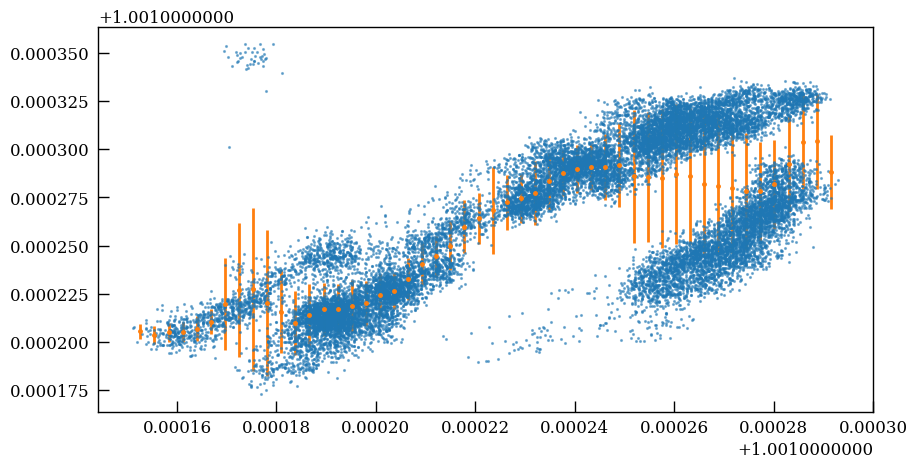

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(data_corr["IE_Card01"].to_numpy(), data_corr["IE_Card02"].to_numpy(), ".", alpha=0.5)
data_rebin = tools.tprofile(data_corr, xCol="IE_Card01", yCol="IE_Card02", num_bins=50)
axes.errorbar(data_rebin[0], data_rebin[1], data_rebin[2], fmt="o")

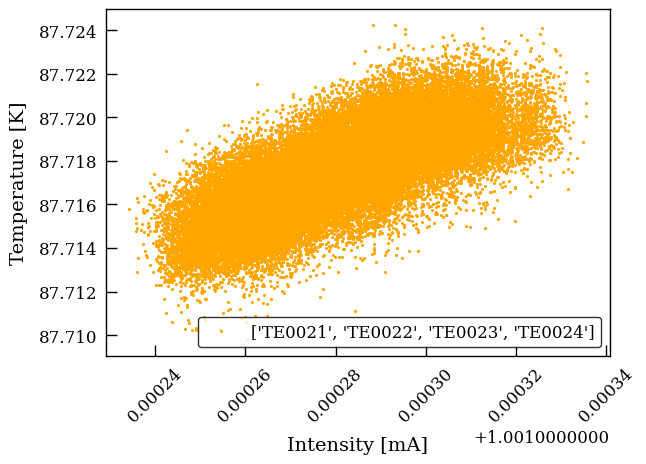

In [48]:
def line(x, A, B):
    return A + B * x

fig, axes = plt.subplots(1, 1)
sampling_time = "10min"
axes.plot(data["IE_Card01"].to_numpy(), data[["TE0021", "TE0022", "TE0023", "TE0024"]].mean(axis=1).to_numpy(), ".", color="orange", label=f'{["TE0021", "TE0022", "TE0023", "TE0024"]}')
axes.set_xlabel("Intensity [mA]")
axes.set_ylabel("Temperature [K]")
axes.legend()
plt.xticks(rotation=45);

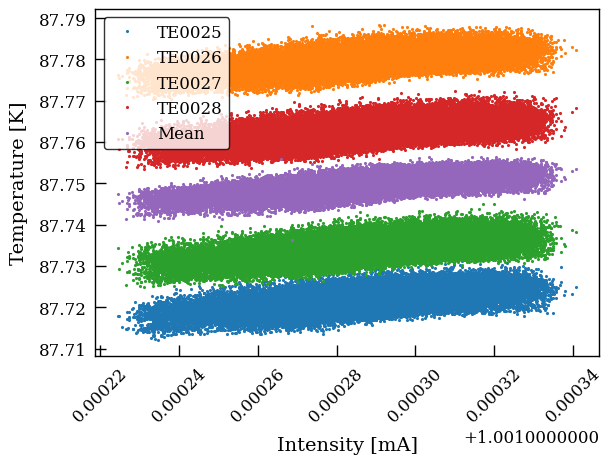

In [49]:
def line(x, A, B):
    return A + B * x

fig, axes = plt.subplots(1, 1)
sampling_time = "10min"
axes.plot(data["IE_Card02"].to_numpy(), data["TE0025"].to_numpy(), ".", label=f'TE0025')
axes.plot(data["IE_Card02"].to_numpy(), data["TE0026"].to_numpy(), ".", label=f'TE0026')
axes.plot(data["IE_Card02"].to_numpy(), data["TE0027"].to_numpy(), ".", label=f'TE0027')
axes.plot(data["IE_Card02"].to_numpy(), data["TE0028"].to_numpy(), ".", label=f'TE0028')
axes.plot(data["IE_Card02"].to_numpy(), data[["TE0025", "TE0026", "TE0027", "TE0028"]].mean(axis=1).to_numpy(), ".", label=f'Mean')
axes.set_xlabel("Intensity [mA]")
axes.set_ylabel("Temperature [K]")
axes.legend(loc="upper left")
plt.xticks(rotation=45);

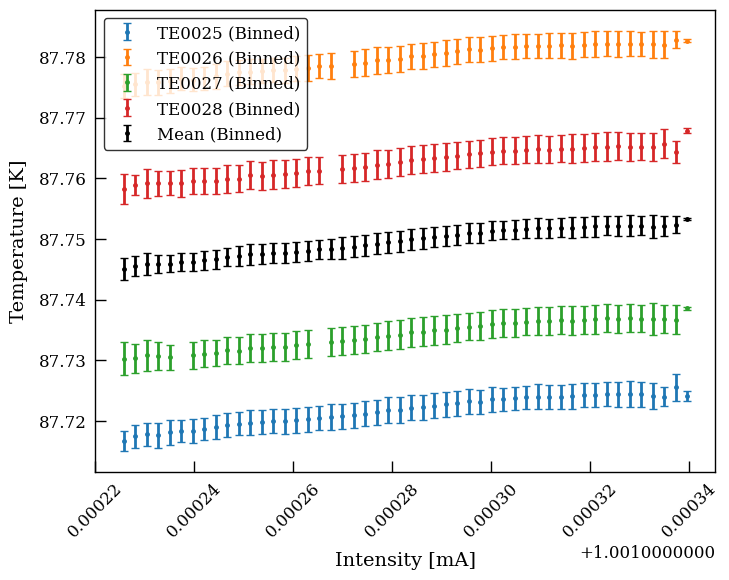

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract X data (common for all curves)
x_data = data["IE_Card02"].to_numpy()

# Define temperature curves
temperature_sensors = ["TE0025", "TE0026", "TE0027", "TE0028"]

# Define bins
num_bins = 50  # Adjust as needed

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ["C0", "C1", "C2", "C3", "C4"]  # Custom colors for curves

# Process each temperature curve separately
for i, sensor in enumerate(temperature_sensors):
    y_data = data[sensor].to_numpy()

    # Compute bin statistics
    bin_means, bin_edges, binnumber = stats.binned_statistic(x_data, y_data, statistic="mean", bins=num_bins)
    bin_stds, _, _ = stats.binned_statistic(x_data, y_data, statistic="std", bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Plot raw data
    #axes.plot(x_data, y_data, ".", alpha=0.3, color=colors[i], label=sensor)

    # Plot binned profile with error bars
    axes.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt="o", color=colors[i], capsize=3, label=f"{sensor} (Binned)")

# Compute and plot the mean of all sensors
y_mean = data[temperature_sensors].mean(axis=1).to_numpy()

# Compute bin statistics for mean curve
bin_means_mean, _, _ = stats.binned_statistic(x_data, y_mean, statistic="mean", bins=num_bins)
bin_stds_mean, _, _ = stats.binned_statistic(x_data, y_mean, statistic="std", bins=num_bins)

# Plot mean profile
axes.errorbar(bin_centers, bin_means_mean, yerr=bin_stds_mean, fmt="o", color="black", capsize=3, label="Mean (Binned)")

# Labels and formatting
axes.set_xlabel("Intensity [mA]")
axes.set_ylabel("Temperature [K]")
axes.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()


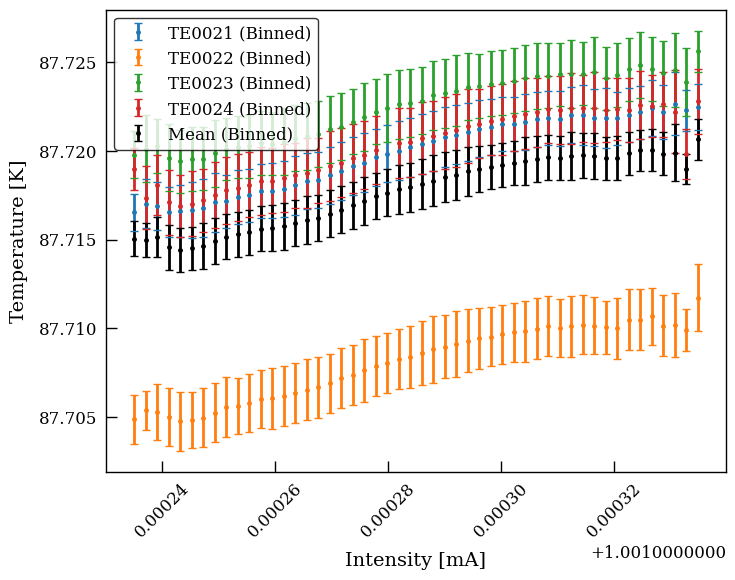

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract X data (common for all curves)
x_data = data["IE_Card01"].to_numpy()

# Define temperature curves
temperature_sensors = ["TE0021", "TE0022", "TE0023", "TE0024"]

# Define bins
num_bins = 50  # Adjust as needed

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ["C0", "C1", "C2", "C3", "C4"]  # Custom colors for curves

# Process each temperature curve separately
for i, sensor in enumerate(temperature_sensors):
    y_data = data[sensor].to_numpy()

    # Compute bin statistics
    bin_means, bin_edges, binnumber = stats.binned_statistic(x_data, y_data, statistic="mean", bins=num_bins)
    bin_stds, _, _ = stats.binned_statistic(x_data, y_data, statistic="std", bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Plot raw data
    #axes.plot(x_data, y_data, ".", alpha=0.3, color=colors[i], label=sensor)

    # Plot binned profile with error bars
    axes.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt="o", color=colors[i], capsize=3, label=f"{sensor} (Binned)")

# Compute and plot the mean of all sensors
y_mean = data[temperature_sensors].mean(axis=1).to_numpy()

# Compute bin statistics for mean curve
bin_means_mean, _, _ = stats.binned_statistic(x_data, y_mean, statistic="mean", bins=num_bins)
bin_stds_mean, _, _ = stats.binned_statistic(x_data, y_mean, statistic="std", bins=num_bins)

# Plot mean profile
axes.errorbar(bin_centers, bin_means_mean, yerr=bin_stds_mean, fmt="o", color="black", capsize=3, label="Mean (Binned)")

# Labels and formatting
axes.set_xlabel("Intensity [mA]")
axes.set_ylabel("Temperature [K]")
axes.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()


Text(0.5, 1.0, 'Slope of the Temperature vs Current: Linear Fit')

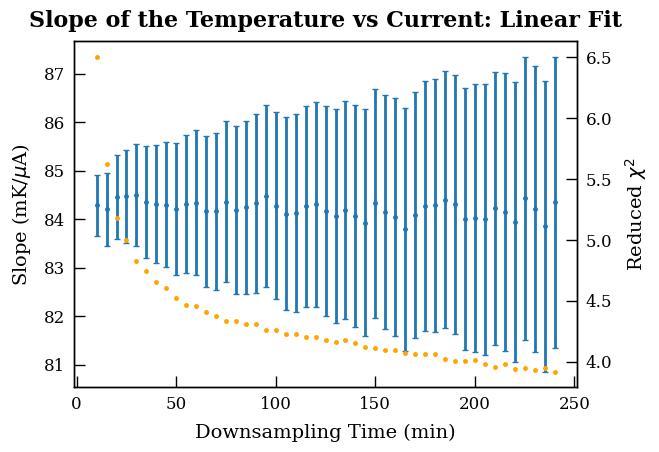

In [15]:
fig, axes = plt.subplots(1,1)
axes2 = axes.twinx()
axes.errorbar(results.index.to_numpy(), results["B"].to_numpy(), yerr=results["B_err"].to_numpy(), fmt="o", capsize=2)
axes2.plot(results.index.to_numpy(), results["redchi"].to_numpy(), "o", color="orange")
axes2.set_ylabel("Reduced $\chi^2$")
axes.set_ylabel(r"Slope (mK/$\mu$A)")
axes.set_xlabel("Downsampling Time (min)")
axes.set_title("Slope of the Temperature vs Current: Linear Fit")

In [20]:
mapping = utils.load_mapping(date=datetime.datetime(2024, 7, 1, 0, 0, 0))
sampling_time = 120
data_plot = data.resample(f"{sampling_time}min").mean()
data_plot_err = data.resample(f"{sampling_time}min").std()
slopes = {}
chan_board = {}
for index, row in mapping.iterrows():
    channel = row["SC-ID"]
    if row["SYSTEM"] == "PIPE" and "I" in row["NAME"]:
        continue
    try:
        int(row["BOARD"])
    except:
        continue
    if int(row["BOARD"]) > 4:
        continue
    try:
        current_channel = f'IE_Card0{int(row["BOARD"])}'
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err[current_channel].to_numpy()**2 + data_plot_err[channel].to_numpy()**2)
        fit_result = line_model.fit((data_plot[channel]).to_numpy(),
                                    params,
                                    x=data_plot[current_channel].to_numpy(), weights=weights)
        if fit_result.redchi > 1e1:
            continue
        slopes[channel] = {"slope":fit_result.params["B"].value, "slope_err":fit_result.params["B"].stderr,
                           "T0":fit_result.params["A"].value, "T0_err":fit_result.params["A"].stderr,
                           "board":int(row["BOARD"]), "current_channel":current_channel}
        if current_channel not in chan_board:
            chan_board[current_channel] = []
        chan_board[current_channel].append(channel)
    except:
        continue
slopes = pd.DataFrame(slopes).T

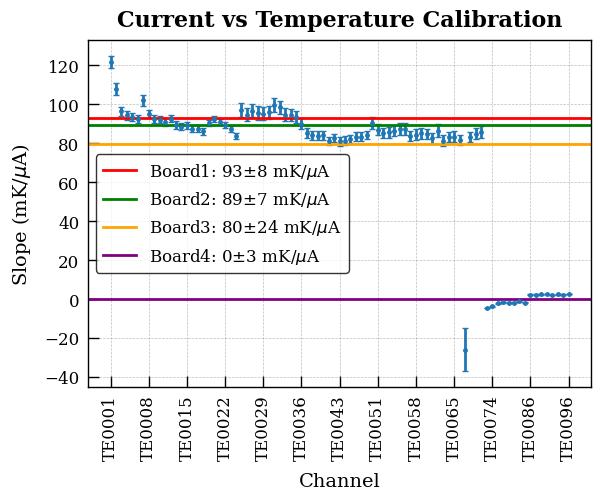

In [21]:
plt.errorbar(slopes.index.to_numpy(), slopes["slope"].to_numpy(), yerr=slopes["slope_err"].to_numpy(), fmt="o", capsize=2)
plt.ylabel(r"Slope (mK/$\mu$A)")
plt.xlabel("Channel")
xticks = slopes.index.to_numpy()
plt.xticks(xticks[::max(1, len(xticks)//11)], rotation=90)
plt.grid("on")
plt.title("Current vs Temperature Calibration")

board1 = slopes.loc[chan_board["IE_Card01"]]
plt.axhline(board1["slope"].mean(), color="red", label=fr'Board1: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card02"]]
plt.axhline(board1["slope"].mean(), color="green", label=fr'Board2: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card03"]]
plt.axhline(board1["slope"].mean(), color="orange", label=fr'Board3: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card04"]]
plt.axhline(board1["slope"].mean(), color="purple", label=fr'Board4: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
plt.legend()

#slopes.to_csv("/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Data/2024-7-1_2024-7-6_current_correction.csv")

Text(0.5, 1.0, 'Current vs Temperature Calibration')

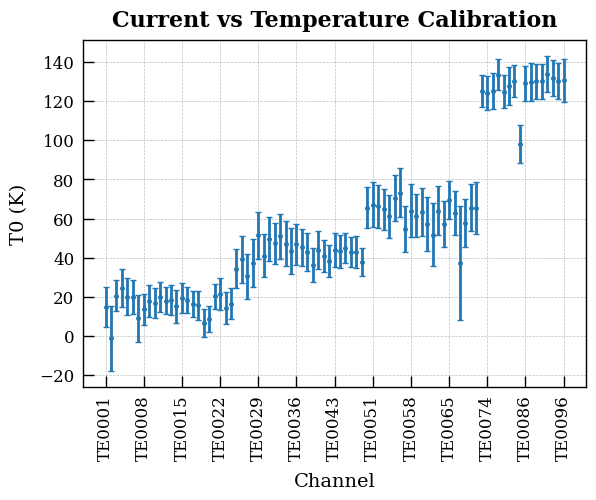

In [8]:
plt.errorbar(slopes.index.to_numpy(), slopes["T0"].to_numpy(), yerr=slopes["T0_err"].to_numpy(), fmt="o", capsize=2)
plt.ylabel(r"T0 (K)")
plt.xlabel("Channel")
xticks = slopes.index.to_numpy()
plt.xticks(xticks[::max(1, len(xticks)//11)], rotation=90)
plt.grid("on")
plt.title("Current vs Temperature Calibration")

In [49]:
tini, tend = datetime.datetime(2024, 8, 10, 0, 0, 0), datetime.datetime(2024, 8, 15, 0, 0, 0)
data, data_err = utils.load_data(tini, tend)

Text(0.5, 1.0, 'NP04 Temperature Evolution')

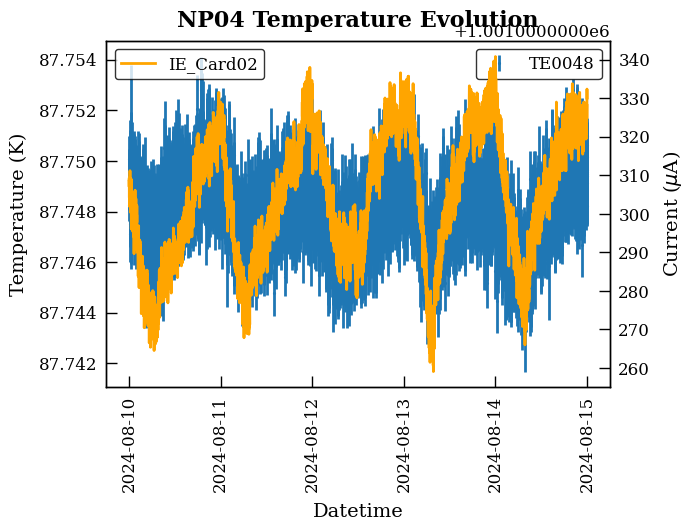

In [50]:
fig, axes = plt.subplots(1, 1)

plots.plot_temp_evolution(
    data=data, data_err=data_err, channel="TE0048",
    tmax=300, tmax_err=1,
    axes=axes
)
#axes.axvline(datetime.datetime(2024, 5, 3, 13, 30, 0), label="Recirculation ON", color="red")
#axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), label="Recirculation ON", color="orange")
axes2 = axes.twinx()
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card02"].to_numpy(), color="orange", label="IE_Card02")
axes.legend()
axes2.legend()
axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature (K)")
axes2.set_ylabel("Current ($\mu$A)")
axes.set_title("NP04 Temperature Evolution")
# fig.savefig(f"{path_to_save_plots}np04_temp_evolution_TE0001.png", format="png")

In [51]:
def line(x, A, B):
    return A + B * x

results = {}
minchi2 = 1e10

sample = list(range(10, 240 + 1, 5))
for minutes in sample:
    i = 48
    try:
        data_plot = data.resample(f"{minutes}min").mean()
        data_plot_err = data.resample(f"{minutes}min").std()
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err["IE_Card02"].to_numpy()**2 + data_plot_err[fr"TE00{i}"].to_numpy()**2)
        fit_result = line_model.fit((data_plot[fr"TE00{i}"]-data_plot[fr"TE00{i}"].iloc[0]).to_numpy(),
                                    params,
                                    x=data_plot["IE_Card02"].to_numpy(), weights=weights)
        if fit_result.redchi > 0.5:
            continue
        results[minutes] = {"redchi":fit_result.redchi, "A":fit_result.params["A"].value, "B":fit_result.params["B"].value, "B_err":fit_result.params["B"].stderr}
        if fit_result.redchi < minchi2:
            minchi2 = fit_result.redchi
            best_minutes = minutes
    except:
        continue
results = pd.DataFrame(results).T
print(results.columns)

Index(['redchi', 'A', 'B', 'B_err'], dtype='object')


In [52]:
mapping = utils.load_mapping(date=datetime.datetime(2024, 11, 2, 0, 0, 0))
sampling_time = 120
data_plot = data.resample(f"{sampling_time}min").mean()
data_plot_err = data.resample(f"{sampling_time}min").std()
slopes = {}
chan_board = {}
for index, row in mapping.iterrows():
    channel = row["SC-ID"]
    if channel == "TE0067":
        continue
    if row["SYSTEM"] == "PIPE" and "I" in row["NAME"]:
        continue
    try:
        int(row["BOARD"])
    except:
        continue
    if int(row["BOARD"]) > 4:
        continue
    try:
        current_channel = f'IE_Card0{int(row["BOARD"])}'
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err[current_channel].to_numpy()**2 + data_plot_err[channel].to_numpy()**2)
        fit_result = line_model.fit((data_plot[channel]).to_numpy(),
                                    params,
                                    x=data_plot[current_channel].to_numpy(), weights=weights)
        if fit_result.redchi > 0.5:
            continue
        slopes[channel] = {"slope":fit_result.params["B"].value, "slope_err":fit_result.params["B"].stderr,
                           "T0":fit_result.params["A"].value, "T0_err":fit_result.params["A"].stderr,
                           "board":int(row["BOARD"]), "current_channel":current_channel}
        if current_channel not in chan_board:
            chan_board[current_channel] = []
        chan_board[current_channel].append(channel)
    except:
        continue
slopes = pd.DataFrame(slopes).T

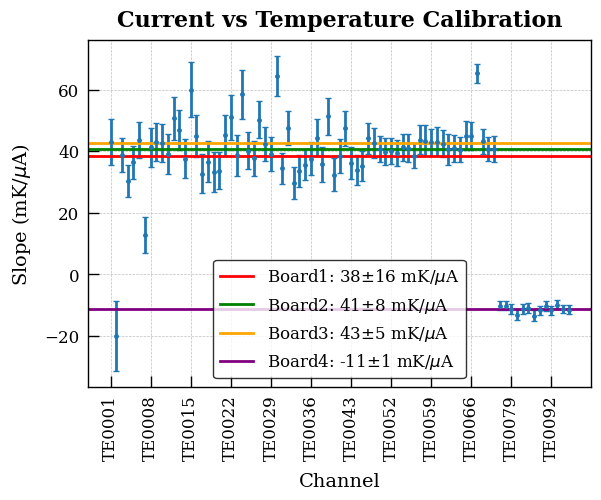

In [53]:
plt.errorbar(slopes.index.to_numpy(), slopes["slope"].to_numpy(), yerr=slopes["slope_err"].to_numpy(), fmt="o", capsize=2)
plt.ylabel(r"Slope (mK/$\mu$A)")
plt.xlabel("Channel")
xticks = slopes.index.to_numpy()
plt.xticks(xticks[::max(1, len(xticks)//11)], rotation=90)
plt.grid("on")
plt.title("Current vs Temperature Calibration")

board1 = slopes.loc[chan_board["IE_Card01"]]
plt.axhline(board1["slope"].mean(), color="red", label=fr'Board1: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card02"]]
plt.axhline(board1["slope"].mean(), color="green", label=fr'Board2: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card03"]]
plt.axhline(board1["slope"].mean(), color="orange", label=fr'Board3: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card04"]]
plt.axhline(board1["slope"].mean(), color="purple", label=fr'Board4: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
plt.legend()

slopes.to_csv("/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Data/2024-7-1_2024-7-6_current_correction.csv")